In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler


import re
from datetime import datetime, date, timedelta


import matplotlib.pyplot as plt
import seaborn as sns
from to_img import to_img



plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 17
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
sns.set(style="ticks", color_codes=True)

## 1. Data

The data consists of text scraped from every search result for 'data science/scientist' on Indeed.com using the [Requests](https://docs.python-requests.org/en/master/ "Requests Library"), Tor, and [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/ "BeautifulSoup") libraries.

### 1.1 Load and Inspect Table

In [2]:
# note the change in memory usage.
data = pd.read_csv('../app/data/total.csv')
print(len(data))
data.info(memory_usage='deep')
data.head()

1128
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   company           1128 non-null   object 
 1   description       1123 non-null   object 
 2   estimated_salary  207 non-null    object 
 3   extractDate       1128 non-null   object 
 4   job_type_items    142 non-null    object 
 5   location          1128 non-null   object 
 6   postDate          1128 non-null   object 
 7   rating            957 non-null    float64
 8   raw_desc_soup     1124 non-null   object 
 9   requirements      59 non-null     object 
 10  salary            708 non-null    object 
 11  summary           1128 non-null   object 
 12  title             1128 non-null   object 
 13  url               1128 non-null   object 
dtypes: float64(1), object(13)
memory usage: 559.9 MB


,company,description,estimated_salary,extractDate,job_type_items,location,postDate,rating,raw_desc_soup,requirements,salary,summary,title,url
0,Regions,Thank you for your interest in a career at Reg...,NaN,2022-06-23,NaN,"Remote in Birmingham, AL 35203",PostedJust posted,3.5,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,Full-time,"Draws insights from data to make quick, well i...",Data Scientist(REMOTE),https://www.indeed.com/rc/clk?jk=50d4c207a2b5f...
1,Protective Life Corporation,The work we do has an impact on millions of...,"['', 'Not provided by employer', ""$78.5K - $99...",2022-06-23,NaN,"Birmingham, AL",PostedToday,3.6,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,Full-time,"As an Associate Data Scientist, you will work ...",Associate Data Scientist,https://www.indeed.com/rc/clk?jk=6a1ee4df8a406...
2,"Modern Technology Solutions, Inc.","Overview: Modern Technology Solutions, Inc. ...","['', 'Not provided by employer', ""$109K - $138...",2022-06-23,NaN,"Huntsville, AL 35806",PostedToday,4.5,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,Part-time,"We offer other employee focused benefits, incl...",Senior Airworthiness Engineer – Complex Softwa...,https://www.indeed.com/rc/clk?jk=0f8c60ed2c842...
3,LOCKHEED MARTIN CORPORATION,COVID-19 continues to significantly impact ou...,NaN,2022-06-23,NaN,"Huntsville, AL 35805",PostedToday,4.0,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,Work on datasets with applied statistics and m...,Data Scientist,https://www.indeed.com/rc/clk?jk=44f2b2a37f2c9...
4,ITAC Solutions,ITAC is assisting a local Birmingham client in...,"['', 'Not provided by employer', ""$93.1K - $11...",2022-06-23,NaN,"Remote in Birmingham, AL 35242",PostedToday,4.1,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,Lead exploratory data analysis to support adva...,Sr. Data Analyst,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...


The following table is a view of the raw data from the scrape. I'll build the target by reducing the pay column to floating point values; this will require text cleaning which will also be conducted for the rest of the table. Location will be split into new columns for City and State while and because Indeed's search results show dates relative to the date the query was made I'll need to use PostDate and ExtractDate build a DatePosted column. It is important to note that JobUrl and date-related columns will not be converted into features for the logistic regression, instead they will be reattached to the data at the end in order to provide additional information and insights through the EC2 application. The only rows that'l  be using for modelling are JobTitle, Company, Summary, Requirements, and Description.

In [3]:
data.columns = map(str.lower, data.columns)
data = data.rename({'title': 'job_title'}, axis=1)

##### Data Dictionary
- company<br>
&nbsp;
&nbsp;name of company
- description<br>
&nbsp;full text description of job
- estimated_salary<br>
&nbsp;Indeed's salary estimation
- extractDate<br>
&nbsp;String(?), date record was webscrapped
- job_type_items<br>
&nbsp;formatted list of 'full-time', 'part-time', etc
- location<br>
&nbsp;state and city/remote
- postDate<br>
&nbsp;date job posting was created
- rating<br>
&nbsp;Indeed.com ascribed company ratings
- raw_desc_soup<br>
&nbsp;raw full description, retained for possible future use/analysis
- requirements<br>
&nbsp;employer-listed educational, aptitude, and experience requirements
- sal_guide_items<br>
&nbsp;formatted list containing redundant characters and the Indeed salary estimate
- salary<br>
&nbsp;if given by employer
- salary_and_jType<br>
&nbsp;formatted list combining salary from salfromsection and job_type_items
- salfromsection<br>
&nbsp;salary, if given, extracted from job description
- summary<br>
&nbsp;brief summaries of each job extracted from sach results
- title<br>
&nbsp;job position title
- url<br>
&nbsp;job posting/description address

In [4]:
# check for duplcates.
print(f'Number of dupes: {sum(data.duplicated())}')
data[data.duplicated() == True]

Number of dupes: 0


,company,description,estimated_salary,extractdate,job_type_items,location,postdate,rating,raw_desc_soup,requirements,salary,summary,job_title,url


The likelihood of seeing duplicates coming from the raw scrapping is very unlikely, but this is still a good check to do in case something changes with Indeed.com's front-end code.

Missing values are another story. It seems that Indeed.com doesn't require employers to provide values for every feature, this certainly seems to be the case with requirements, not to mention everywhere salary information coud be held.\
Others, like estimated salary and ratings are generated by Indeed.com but don't exist for every posting.\
job_type_items and salary_and_jType will likely be collapsed into a new column for job types, I'll also do the same with all of the salary related features to build the model's target.

### 1.1 Diagnose Data
In order to proceed with any statistical or exploratory data analysis I will need to wrangle the data quite a bit.
Here, I'll list each of the current feature columns and briefly describe what I'll need to do with them.

Column Groups and Needs
Simple
Salary
Text
etc

#### 1.2 Features


In [5]:
data.nunique().sort_values(ascending=False)

raw_desc_soup       1124
url                  519
location             322
description          284
summary              283
job_title            220
company              217
estimated_salary      71
salary                61
rating                21
requirements          20
postdate               5
job_type_items         4
extractdate            1
dtype: int64

In [6]:
#check for missing
print(data.isna().sum().sort_values(ascending=False))

requirements        1069
job_type_items       986
estimated_salary     921
salary               420
rating               171
description            5
raw_desc_soup          4
company                0
extractdate            0
location               0
postdate               0
summary                0
job_title              0
url                    0
dtype: int64


In [7]:

print(f"The {data.shape[0]} rows of data have {data.shape[1]} features. Since this is a classification problem I'll be selecting one to be the target, leaving me with {data.shape[1]-1} dependent variables to work with.")


The 1128 rows of data have 14 features. Since this is a classification problem I'll be selecting one to be the target, leaving me with 13 dependent variables to work with.


##### 1.2a Rating

As the only feature coming in with numeric (float) values I should just need to scale it. I'll address missing values by imputing zero. The rationale behind this is that an unrated company should simply be rated as zero.
print(sorted(data.rating.unique()))

In [8]:
data[data.rating.isnull()].head(3)

,company,description,estimated_salary,extractdate,job_type_items,location,postdate,rating,raw_desc_soup,requirements,salary,summary,job_title,url
28,"ICW Group Holdings, Inc",Are you looking for more than just a job? Do y...,"['', 'Not provided by employer', ""$103K - $130...",2022-06-23,NaN,"San Diego, CA 92128",PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,Full-time,Utilizes advanced data mining techniques to di...,Data Scientist,https://www.indeed.com/rc/clk?jk=50ce10da7e8a3...
31,Aideo Technologies,Aidéo Technologies provides solutions that aut...,NaN,2022-06-23,['Full-time'],"Pleasanton, CA 94566",PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",Master's (Required)Python: 2 years (Required),"$135,000 - $180,000 a year - Full-time",The data science team is responsible for our c...,Machine Learning Engineer,https://www.indeed.com/company/Aideo-Technolog...
32,Rubrik Job Board,Job SummaryAbout Team & About Role:Jarvis is t...,"['', 'Not provided by employer', ""$106K - $134...",2022-06-23,NaN,"Palo Alto, CA",PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,Familiarity with one or more of the following ...,"Software Engineer - Jarvis, Data Platform",https://www.indeed.com/rc/clk?jk=c58e002167d88...


In [9]:
def missing(data,feature):
    data_len = len(data)
    missing_len = len(data[data[feature].isnull()])
    try:
        print(f'Percent Missing: {round(data_len/missing_len,1)}%')
    except:
        print('nothing missing')

    notna = data[feature].notna()

    print(f'Number Missing: {missing_len}')

    print(np.mean(data[notna]['rating']))

    return data[feature].describe()
        
missing(data, feature = 'rating')



Percent Missing: 6.6%
Number Missing: 171
3.7700104493207944


count    957.000000
mean       3.770010
std        0.377602
min        2.400000
25%        3.600000
50%        3.900000
75%        4.000000
max        5.000000
Name: rating, dtype: float64

For now I'll drop these. I'm considering what and how to impute. What I'd like to do is run clustering on the data, or perhaps logistic regression. One thing I know is that the picture will become clearer as I gain more data. For now though, the amount of missing values is very small.

957


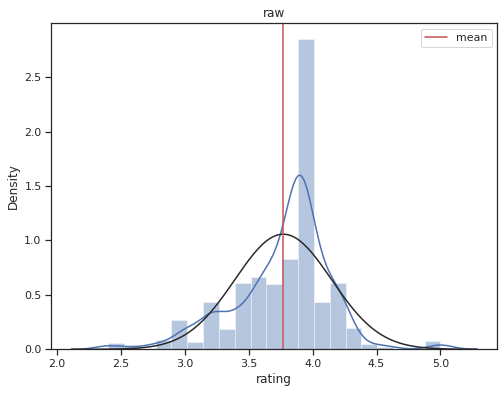

In [10]:
data = data[data['rating'].notnull()]
print(len(data))

ax = sns.distplot(data.rating, fit=norm, bins=data.rating.nunique(), kde=True)
plt.title('raw')
#ax.set_xticks(data.rating.unique())
plt.axvline(x=np.mean(data.rating), label='mean', c = 'r')
plt.legend()
plt.show()

outliers

In [11]:
outliers = []
def z_detect(data, feature):
    sample = data[feature]
    threshold=3
    mean = np.mean(sample)
    std = np.std(sample)
    
    for i in sample:
        z_score = (i-mean)/std
        if np.abs(z_score) > threshold:
            outliers.append(i)
    if len(outliers) == 0:
        pass
    else:
        return sorted(outliers)
z_detect(data, feature = 'rating')


[2.4,
 2.4,
 2.4,
 2.4,
 2.4,
 2.4,
 2.4,
 2.6,
 2.6,
 2.6,
 2.6,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0]

There are 9 records below and 22 above.


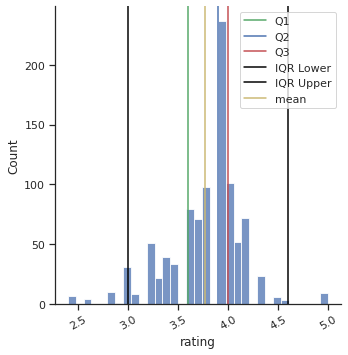

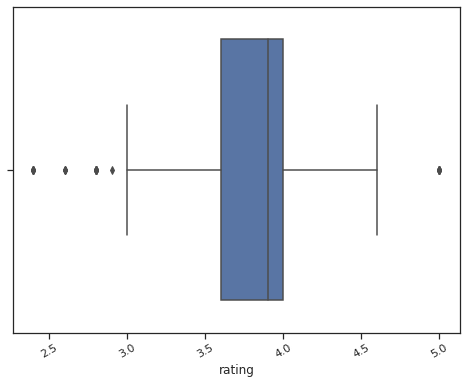

957
926


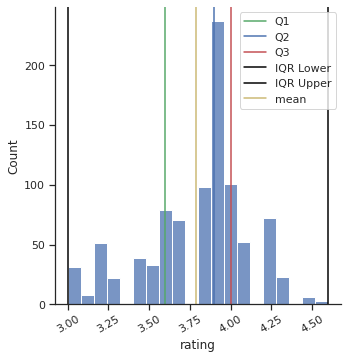

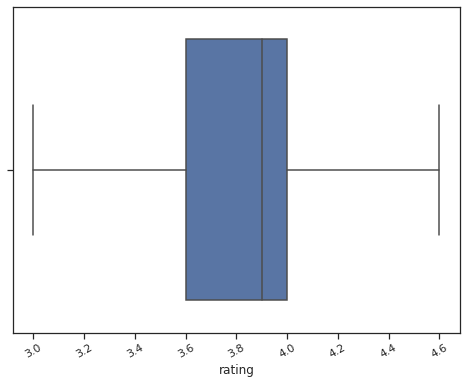

In [12]:
def iqr_detect(data):
    q1 = np.quantile(data.rating, 0.25)
    q2 = np.quantile(data.rating, 0.5)
    q3 = np.quantile(data.rating, 0.75)

    # calc iqr
    iqr = (q3 - q1)
    
    # expand iqr to discern outliers
    iqr_x = iqr*1.5

    # setting the lower and upper limits
    iqr_lower = q1-iqr_x
    iqr_upper = q3+iqr_x

    # report
    print(f'There are {len(data[data.rating > iqr_upper])} records below and {len(data[data.rating < iqr_lower])} above.')



    # plotting
    sns.displot(data.rating)
    plt.axvline(x=q1, label="Q1", c = 'g')
    plt.axvline(x=q2, label="Q2", c = 'b')
    plt.axvline(x=q3, label="Q3", c = 'r')

    plt.axvline(x=iqr_lower, label = 'IQR Lower', c = 'black')
    plt.axvline(x=iqr_upper, label = 'IQR Upper', c = 'black')
    plt.axvline(x=np.mean(data.rating), label='mean', c = 'y')
    plt.xticks(rotation=30)
    plt.legend()
    plt.show()

    sns.boxplot(data=data, x='rating')
    plt.xticks(rotation=30)
    plt.show()

    
    # trimming outliers
    trimmed = data[data.rating > iqr_upper]
    trimmed = data[data.rating < iqr_lower]
    print(len(data))
    data = data[data.rating <= iqr_upper]
    data = data[data.rating >= iqr_lower]
    print(len(data))



    # plotting
    sns.displot(data.rating)
    plt.axvline(x=q1, label="Q1", c = 'g')
    plt.axvline(x=q2, label="Q2", c = 'b')
    plt.axvline(x=q3, label="Q3", c = 'r')

    plt.axvline(x=iqr_lower, label = 'IQR Lower', c = 'black')
    plt.axvline(x=iqr_upper, label = 'IQR Upper', c = 'black')
    plt.axvline(x=np.mean(data.rating), label='mean', c = 'y')
    plt.xticks(rotation=30)
    plt.legend()
    plt.show()

    sns.boxplot(data=data, x='rating')
    plt.xticks(rotation=30)
    plt.show()
    return data, trimmed

data, trimmed = iqr_detect(data)

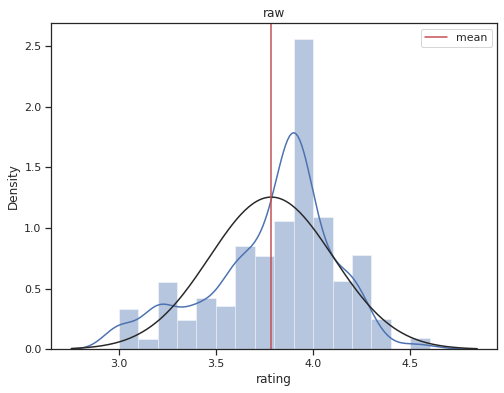

In [13]:
ax = sns.distplot(data.rating, fit=norm, bins=data.rating.nunique(), kde=True)
plt.title('raw')
#ax.set_xticks(data.rating.unique())
plt.axvline(x=np.mean(data.rating), label='mean', c = 'r')
plt.legend()
plt.show()


In [14]:
data.rating.describe()

count    926.000000
mean       3.784881
std        0.318287
min        3.000000
25%        3.600000
50%        3.900000
75%        4.000000
max        4.600000
Name: rating, dtype: float64

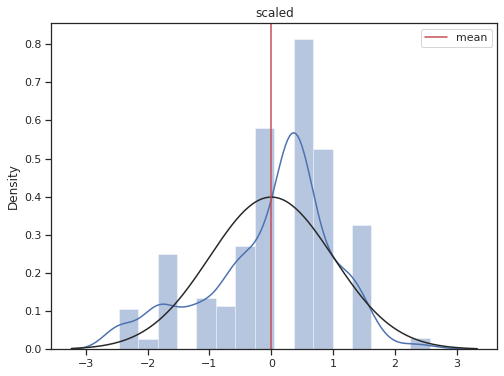

count    9.260000e+02
mean     3.980497e-16
std      1.000540e+00
min     -2.467291e+00
25%     -5.811780e-01
50%      3.618783e-01
75%      6.762305e-01
max      2.562343e+00
Name: rating, dtype: float64

In [15]:


scalar = StandardScaler()
scaled_ratings = pd.DataFrame(scalar.fit_transform(pd.DataFrame(data.rating)), columns=['rating'])

scalar = StandardScaler()
scaled_ratings = pd.DataFrame(scalar.fit_transform(pd.DataFrame(data.rating)), columns=['rating'])
ax = sns.distplot(scaled_ratings, fit=norm, bins=data.rating.nunique(), kde=True)
plt.title('scaled')
#ax.set_xticks(data.rating.unique())
plt.axvline(x=np.mean(scaled_ratings.rating), label='mean', c = 'r')
plt.legend()
plt.show()

scaled_ratings.rating.describe()


##### 1.2a Dates

'extractdate' & 'postdate'\
extract_date is a string showing the day the record was webscrapped.
post_date is a string description of the relative age of each post from the date it was posted to the day it was webscrapped.
Converting post_date to a number will give me the the posts ae, which I'll then subtract from it's extract date in order to build a new feature carrying values for the DATE each job posting has been submitted to Indeed.com.

The extractdate is the value given by my parser representing the date the data was pulled from Indeed.com.\
The postdate is how many days have passed since the post was made and when the search was conducted (by my webscraper).\
The task is to find the delta (difference), the intervening days since the post was made, and subtract it from the extract date so I can get the actual date publishd.

In [16]:
data[['extractdate', 'postdate']].head()

,extractdate,postdate
0,2022-06-23,PostedJust posted
1,2022-06-23,PostedToday
2,2022-06-23,PostedToday
3,2022-06-23,PostedToday
4,2022-06-23,PostedToday


In [17]:
print(missing(data, feature = 'extractdate'),'\n')
print(missing(data, feature = 'postdate'))

nothing missing
Number Missing: 0
3.7848812095032396
count            926
unique             1
top       2022-06-23
freq             926
Name: extractdate, dtype: object 

nothing missing
Number Missing: 0
3.7848812095032396
count             926
unique              5
top       PostedToday
freq              436
Name: postdate, dtype: object


In [18]:
print(data.postdate.unique(),'\n')
print(data.extractdate.unique(),'\n')
print(data.postdate.value_counts(),'\n')
print(data.extractdate.value_counts())

['PostedJust posted' 'PostedToday' 'Posted1 day ago'
 'PostedPosted 1 day ago' 'Hiring ongoing'] 

['2022-06-23'] 

PostedToday               436
PostedJust posted         242
Posted1 day ago           116
PostedPosted 1 day ago    114
Hiring ongoing             18
Name: postdate, dtype: int64 

2022-06-23    926
Name: extractdate, dtype: int64


In [19]:
def postD(row):
    """Critical function that converts postdate values into relative (in days) distance from the extract date.
    Args:
        data (string): text descrption of how old the post is.
    Returns:
        npnan or int: numeric representation of post age
    """
    if row['postdate'] != np.nan:
        if row['postdate'] in ['PostedToday', 'PostedJust posted', 'Hiring ongoing']:
            delta = timedelta(0)
        elif row['postdate'] in ['PostedPosted 1 day ago', 'Posted1 day ago']:
            delta = timedelta(1)

         
        value = pd.to_datetime(row['extractdate'])-delta
    return value



data['dateposted'] = data.apply( lambda row : postD(row), axis = 1)

data[['extractdate', 'postdate','dateposted']].head()

,extractdate,postdate,dateposted
0,2022-06-23,PostedJust posted,2022-06-23
1,2022-06-23,PostedToday,2022-06-23
2,2022-06-23,PostedToday,2022-06-23
3,2022-06-23,PostedToday,2022-06-23
4,2022-06-23,PostedToday,2022-06-23


##### 1.2b Salary

'salary'\
Several different approaches will need to be used to extract salary information from this feature because employers provide this information themselves.
For one example, the pay periods of hour, day, week etc will need to be scaled to an anuual scale so I can have a standard scale to start wiith.
The salary ranges also appear here, so I'll be extracting numeric string characters, converting them into floats representing the lower and upper bounds of each range, and taking their medaian value.

'estimated_salary'\



'sal_guide_items'\


'salary_and_jtype' & 'salfromsection'\
These will be wrangled in much the same way. The only other pertinent information in these features would be the job_type data already found in job_type_items,


The 'salary' feature is whatever information the employer provided. There are several subgroups within these values:\
&nbsp;work week\
While I could convert these to lists, the only information I need (salary) can be parsed out.


The 'estimated_salary' feature 
Indeed.com provides its own salary estimates in what appear to be bins.
These and all other salary ranges will be collapsed to their median values once I've extracted and converted their numeric string reresentations.



The task is to find the delta (difference), the intervening days since the post was made, and subtract it from the extract date so I can get the actual date publishd.

In [20]:
print(data.salary.unique()[:])
print(data.estimated_salary.unique()[:3],'\n')
data[['salary','estimated_salary']].head(3)
x = data[['salary','estimated_salary']]
for i in x:
    print(i)


['Full-time' 'Part-time' nan '$100,000 - $175,000 a year -  Full-time'
 '$115,599 - $176,300 a year -  Full-time'
 'From $90,000 a year -  Full-time'
 '$190,000 - $225,000 a year -  Full-time'
 '$124,800 a year -  Full-time, Contract'
 'Up to $140,000 a year -  Full-time'
 '$90,000 - $115,000 a year -  Full-time'
 '$150,000 - $200,000 a year -  Full-time' 'Full-time, Contract'
 '$130,000 - $150,000 a year' '$101,400 - $152,200 a year'
 '$90,000 a year -  Full-time' '$130,000 - $180,000 a year -  Full-time'
 '$70 - $90 an hour -  Full-time, Contract'
 '$100,000 - $190,000 a year -  Full-time'
 '$65,000 - $75,000 a year -  Full-time'
 '$80,000 - $90,000 a year -  Full-time' '$22 - $25 an hour -  Contract'
 '$130,000 - $160,000 a year' 'Up to $190,500 a year -  Full-time'
 '$120,000 - $160,000 a year -  Full-time' 'Full-time, Internship'
 '$170,000 - $200,000 a year -  Full-time'
 '$100,000 - $150,000 a year -  Full-time'
 '$65,000 - $90,000 a year -  Full-time'
 '$108,545 - $127,700 a ye

In [21]:
def justNumbers(data):
    if type(data) == str:
        # for estimatedsalary col
        if bool(re.search(r'Not provided by employer', data)):
            est = data.split(',')
            est = est[2].split('a year')[0]
            est = re.sub(r'[(a-zA-Z,&,$)]+' '|:]',r'',est)
            est = est.replace("-","")
            est = est.replace('"',"")
            est1 = est.split()[0]
            est2 = est.split()[1]
  


            return (float(est1)+float(est2))/2
        # for salary col
        else:
            if bool(re.search(r'$', data)):
                if bool(re.search(r'\d', data)):
                    if bool(re.search(r' - ', data)):
                        z = data.split(' - ')
                        sal = z[0]+' '+z[1]
                    else:

                        sal = data


                    sal = re.sub(r'[?|!|\'|"|#|/|-|(|)|$|' '|:]',r'',sal)
                    sal = re.sub(r'[(a-zA-Z,&)]+' '|:]',r'',sal)
                    sal = sal.replace("-","")
                    sal = sal.strip()
                    if bool(re.search(r' ', sal)):
                        sal1 = sal.split(' ')[0]
                        sal2 = sal.split(' ')[1]
                        if bool(re.search(r'hour', data)):
                            return ((float(sal1)+float(sal2))/2)*40*(365/7)
                        else:
                            return (float(sal1)+float(sal2))/2
                    else:
                        return float(sal)
            
        return None

        



data['cleanedsal'] = data.salary.apply(justNumbers)
data['cleanedest'] = data.estimated_salary.apply(justNumbers)

data['cleanedsal'].unique()

array([            nan, 137500.        , 145949.5       ,  90000.        ,
       207500.        , 124800.        , 140000.        , 102500.        ,
       175000.        , 126800.        , 155000.        , 166857.14285714,
       145000.        ,  70000.        ,  85000.        ,  49014.28571429,
       190500.        , 185000.        , 125000.        ,  77500.        ,
       118122.5       , 112205.        , 130110.5       ,  66400.        ,
        84000.        , 174000.        , 115000.        , 104000.        ,
        92814.28571429,  30469.5       , 176600.        ,  92801.        ,
        95000.        ])

In [22]:
def salaries(row):
    """Critical function that converts postdate values into relative (in days) distance from the extract date.
    Args:
        data (string): text descrption of how old the post is.
    Returns:
        npnan or int: numeric representation of post age
    """
    if (row['cleanedest'] >0) or (row['cleanedsal'] >0):
        if (row['cleanedest'] >0):
            return float(row['cleanedest'])
        else:
            return float(row['cleanedsal'])

data['salaries'] = data.apply( lambda row : salaries(row), axis = 1).astype(float)


In [23]:
cols = ['salary','cleanedsal','estimated_salary','cleanedest','salaries']
for i in cols:
    print(i)
    print(len(data[i].unique()),'\n')

data[cols].head(3)

salary
43 

cleanedsal
33 

estimated_salary
42 

cleanedest
38 

salaries
70 



,salary,cleanedsal,estimated_salary,cleanedest,salaries
0,Full-time,NaN,NaN,NaN,NaN
1,Full-time,NaN,"['', 'Not provided by employer', ""$78.5K - $99...",89.0,89.0
2,Part-time,NaN,"['', 'Not provided by employer', ""$109K - $138...",123.5,123.5


In [24]:
sorted(list(data['salaries'].unique()))

[nan,
 67.4,
 86.8,
 89.0,
 89.4,
 90.3,
 91.2,
 91.25,
 94.05,
 95.75,
 99.4,
 102.15,
 104.65,
 105.55,
 107.5,
 108.4,
 109.05,
 111.9,
 112.7,
 115.5,
 117.0,
 118.0,
 120.0,
 123.5,
 124.5,
 125.0,
 126.0,
 131.5,
 132.5,
 133.0,
 134.0,
 134.5,
 135.0,
 136.0,
 137.0,
 144.0,
 147.0,
 150.5,
 30469.5,
 49014.28571428572,
 66400.0,
 70000.0,
 77500.0,
 84000.0,
 85000.0,
 90000.0,
 92801.0,
 92814.28571428572,
 95000.0,
 102500.0,
 104000.0,
 112205.0,
 115000.0,
 118122.5,
 124800.0,
 125000.0,
 126800.0,
 130110.5,
 137500.0,
 140000.0,
 145000.0,
 145949.5,
 155000.0,
 166857.14285714287,
 174000.0,
 175000.0,
 176600.0,
 185000.0,
 190500.0,
 207500.0]

In [ ]:
def clean_text(data):
    sentences = data.split('.')
    clean_sentences = []
    for i in sentences:
        clean_sentence = re.sub(r'[?|!|\'|"|#|/|-|,(|)|$|-|' '|:]',r'',i)
        clean_sentence = re.sub(r'[?|!|\'|"|#|/|-|,(|)|$|-|' '|:]',r'',clean_sentence)
        clean_sentence = "  ".join(re.findall("[(a-zA-Z,&)]+", clean_sentence))
        clean_sentences.append(clean_sentence)
    clean_text = ''
    for i in clean_sentences:
        clean_text += (' '+i)
    return clean_text.strip(' ')

    

data['cleaned'] = data.text.apply(clean_text)

In [27]:
null = sum(data.salaries.isnull())
nnull = sum(data.salaries.notnull())
print('')
print(f'The data contains {data.shape[0]} rows of individual job postings with values for {data.shape[1]} columns based on\n different sections of each post\'s web page.')
print('')
print(f'- Out of {len(data)} job postings {nnull} or {round(nnull/len(data)*100,2)}% include some sort of salary information,\n- The remaining {null} rowws, or {round(null/len(data)*100,2)}% are missing salary data.')
#\n- Also, there are no null values in the rest of the table meaning we won\'t need\n  to lose any data by dropping rows. While the null values in the Pay column will\n  simply be dropped after we translate the not nulls into the target.')


The data contains 926 rows of individual job postings with values for 18 columns based on
 different sections of each post's web page.

- Out of 926 job postings 206 or 22.25% include some sort of salary information,
- The remaining 720 rowws, or 77.75% are missing salary data.


'job_type_items'\
    I'm going to treat these as likert values, converrting each of these string formatted lists into an ordinal values for a new column.


In [36]:
data = data.copy()

In [48]:
data[data['salaries'].notna()].salaries

1           89.00
2          123.50
4          105.55
5       137500.00
8       145949.50
          ...    
1082    176600.00
1084     92801.00
1087       111.90
1099     95000.00
1111     95000.00
Name: salaries, Length: 206, dtype: float64

In [49]:
print(missing(data, feature = 'salaries'))

Percent Missing: 1.3%
Number Missing: 720
3.7
count       206.000000
mean      75755.730166
std       72102.344171
min          67.400000
25%         120.000000
50%       92801.000000
75%      139375.000000
max      207500.000000
Name: salaries, dtype: float64


In [50]:
print(missing(data, feature = 'job_type_items'))

Percent Missing: 1.1%
Number Missing: 832
3.6936170212765975
count                94
unique                3
top       ['Full-time']
freq                 87
Name: job_type_items, dtype: object


In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 926 entries, 0 to 1127
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   company           926 non-null    object        
 1   description       922 non-null    object        
 2   estimated_salary  89 non-null     object        
 3   extractdate       926 non-null    object        
 4   job_type_items    94 non-null     object        
 5   location          926 non-null    object        
 6   postdate          926 non-null    object        
 7   rating            926 non-null    float64       
 8   raw_desc_soup     923 non-null    object        
 9   requirements      17 non-null     object        
 10  salary            558 non-null    object        
 11  summary           926 non-null    object        
 12  job_title         926 non-null    object        
 13  url               926 non-null    object        
 14  dateposted        926 non

In [ ]:




def jobtype(data):
    """Used for creating a new feature containing nominal values for the job type.

    Args:
        data (string): Values from the 'job_type_items' column.

    Returns:
        string: Extracted and simplified values for each category.
    """
    if type(data) == str:
        if re.search('full', data):
            out = 'full'
        if re.search('part', data):
            out = 'part'
        if re.search('contract', data):
            out = 'contract'
        if re.search('temp', data):
            out = 'temp'
        return out
    else:
        pass

cols = ['company','description', 'job_type_items','location','postdate','requirements',	'summary','job_title']
for txt_col in cols:
    data[txt_col] = data[txt_col].str.lower()



data['jobtype'] = data.job_type_items.apply(jobtype)

data['text'] = data.description+' '+data.summary
#TODO add requirements

cols = ['job_type_items','raw_desc_soup','url','description','summary','requirements']


data.text = data.text.replace(')',' ')



data = annual(data)
#data.schedule.value_counts() keep and eye on this, may have to deal with more than just hourly

'location'\
This feature holds a wealth of information: state, city/remote, and in some cases a zip code.
Zip codes seem to be a recent addition to the information I can get from Indeed.com but since its presence is rather sparse I'll just extract city/remote and state values, splitting them into their respective columns.

In [ ]:
data.job_type_items.unique()

'job_title'\
Although the webscrapper searches for 'data scientist' the results contain over 80 unique job titles. This is largely due to a prefix or suffix that provides the role's specialization at that particular company for that particular job posting. These include items like 'Marketing', 'Senior', 'Geospatial...'.
I'll start by cleaning and simplifying these values, i.e. appearences of 'Sr' can be converted to 'Senior'. This will significantly reduce the number of unique values, hopefully increasing model accuracy.

In [ ]:
print(len(data.job_title.unique()))
data.job_title.unique()[:10]

'requirements'\
I will most likely merge this in with the description prior to conducting NLP. The rationale is that these explicit requirements may be echoed in the description or summary, so by adding them to the corpus I'll raise the scores derived from their increaseed frequency. Eventually I wiuld like to build a set of requirements that I can use in with a clustering algorithm, like KNN, to find/define subgroups within the sample population.

In [ ]:
data.requirements[0]

'summary'\
Much like the description, these are unique. COming from the search results page itself, these are brief descriptions of each job. In most cases this is not merely an abridgement of the summary. Like 'requirement' I'll start by lumping these texts in with description so analysis of the corpus can be boosted by the added descriptions.

In [ ]:
for i in data.summary[:3]:
    print(i)

'description'\
Each value is a unique string of the full job description. I'll lower and remove special characters but this feature will be dealt with seperately in its own NLP process.


'raw_desc_soup'\
I'm only saving this in case I refine or change my parsing. Below is a truncated slice of one of the raw records.

'url'\
Like raw_doc_soup, I'm simply keeping these in case I need to go back and re-parse the raw data. In fact, this URL points directly to the page where that raw doc soup is found.
I may also be able to detect job post updates and duplicates by using these unique addresses.

In [ ]:
data.raw_desc_soup[1][:1000]
data.url[0]

### 2.3 Wrangling & Feature Engineering
Below are the implementations of the data wrangling steps I described above for each feature. Using Numpy, Regex, and Pandas I'll simutaneaously clean the strings, extract and convert numeric information, and create new feature columns.

Let's see what the data looks like at this point. It looks like the 17 original features have been reduced to 11. Most of the columns have been collapsed and cleaned, too. Just a bit more work till this is ready for EDA, NLP, and transformations.

In [ ]:
data

In [ ]:


data.rating = data.rating.fillna(0)

cols = ['extractdate','postdate','schedule','jobtype','salary']
data.drop(cols,inplace=True,axis=1)
data = data.rename({'annual_sal': 'salary'}, axis=1)

data['salary'] = data['salary'].apply(sal_fixer)

In [ ]:
data.salary

In [ ]:
def states_(i):
    """Extracts state values from location

    Args:
        i (string): values from location

    Returns:
        string: extracted state value
    """
    if ',' in i:
        fix =  i.partition(',')[2].strip()
        if len(fix) >2:
            return fix[:2]
        else:
            return fix
    if ',' not in i:
        return i
    elif 'remote' in i:
        return 'remote'


def cities_(i):
    """Extracts city values from location

    Args:
        i (string): values from location

    Returns:
        string: extracted city value
    """
    if ',' in i:
        return i.partition(',')[0]
    if ',' not in i:
        return i
    elif 'remote' in i:
        return 'remote'

data['state'] = data.location.apply(states_)
data['city'] = data["location"].apply(cities_)
#data[data.state.isnull()] = 'remote'

In [ ]:
data.columns
cols = ['salary','estimated_salary', 'job_type_items','raw_desc_soup', 'sal_guide_items','salary_and_jtype', 'salfromsection']
data.drop(cols,inplace=True,axis=1)
data.rename(columns={'final_sal': 'salary'},inplace=True)

data = data[data.description != 'NaN']

len(data)

data.description.value_counts()[1:]

### 2.4 Assessment

In [ ]:
data.info(memory_usage='deep')
data.head()

In [ ]:
shape = data.shape
print(f"The {shape[0]} rows of data now have {shape[1]} variables whose values are now cleaned and typed properly.\nThe only missing values are in Salary which is my target.\nNext, I'll conduct analysis, encoding, and scaling of each feature, starting with Salary which .")
data.describe(include = 'all')


In [ ]:
sns.countplot(x='salary', data=data.notnull(), palette='Set3')
plt.show()

In [ ]:
null = len(data[data.salary.isnull()])
nnull = len(data[data.salary.notnull()])
print(f'{round(nnull/len(data)*100,2)}% of the data has salary information, should be an easy target')

In [ ]:
data = data[data['text'].notna()]

In [ ]:
data.to_csv(f'../app/data/wrangled_data.csv', index=False)

In [ ]:
data

In [ ]:
munged = data
munged

In [ ]:
null = len(munged[munged.salary.isnull()])
nnull = len(munged[munged.salary.notnull()])
print(f'Droping {len(data)-len(munged)} duplicates and out of date posts leaves {len(munged)} rows of data for the regressor to be trained and tested on.')
print(f'- Of those {len(munged)} job postings {nnull} or {round(nnull/len(munged)*100,2)}% include salary information,\n- The remaining {null} rows, or {round(null/len(munged)*100,2)}% are missing salary data.')

## EDA

In [ ]:
import numpy as np
import pandas as pd

from sklearn import metrics
from scipy.stats import pearsonr, chi2_contingency
from sklearn.preprocessing import StandardScaler, MinMaxScaler



import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta

plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['font.size'] = 17

import seaborn as sns
import re
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
sns.set(style="ticks", color_codes=True)
%matplotlib inline

### Target

### Numeric Features
### Categorical Features
### Feature Associations
#### Feature Selection and Hyperparameter Tuning
### Pipeline GridSearch
## Modelling
## Evaluations

## Detecting Outliers: Using both the Z-Score and IQR methods
    Now that preprocessed the data and building the target variable of Salary let's see conduct a bit more EDA to see if there are any outliers that could potentially skew how the regressor will learn from the training data.

In [ ]:
ax = sns.pairplot(data=munged[munged.salary.notnull()],
                  x_vars=['dateposted'],
                  y_vars=['salary'], height=8, hue="salary", palette="crest")

ax.fig.set_size_inches(18,4)

A plot is helpful in isualizing data, but let's program a few functions to detect and remove outliers based on thresholds.
With the Z-Score, we can determine any data outside 3 standard deviations from the mean of our salary data to be an outlier.
Wheras with the interquartile (IQR) range, the middle 50% of given salaries, I'll set the conventional cutoff of 1.5+/- the IQR as the cutoff.
Values found outside of either range will be collected into a list and that'll allow for some fancy indexing so those particular postings can be examined and removed programatically.

#### Z-Score
Salaries 3 standard deviations away from the mean will be listed as outliers.

In [ ]:
outliers = []
def z_detect(munged):
    sample = munged[munged['salary'].notnull()].salary
    threshold=3
    mean = np.mean(sample)
    std = np.std(sample)
    
    for i in sample:
        z_score = (i-mean)/std
        if np.abs(z_score) > threshold:
            outliers.append(i)
    if len(outliers) == 0:
        pass
    else:
        return outliers
z_detect(munged)

In [ ]:
munged

#### IQR
Salaries outside 1.5 times the interquartile range boundaries, either above or below will be listed as outliers.

In [ ]:
def iqr_detect(munged):
    sample = munged[munged['salary'].notnull()].salary
    Q1, Q3 = np.percentile(sample,[25,75])
    iqr = Q3-Q1
    lower_bound = Q1-(1.5*iqr)
    upper_bound = Q3+(1.5*iqr)
    for i in sample:
        if (i < lower_bound)  | (i > upper_bound):
            outliers.append(i)
    if len(outliers) == 0:
        pass
    else:
        return outliers
set(iqr_detect(munged))

In [ ]:
def unique(list1):
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    for x in unique_list:
        print(x)
        
mn = min(outliers)
mx = max(outliers)
print(f'The {len(set(outliers))} Unique Outliers Are:')
unique(outliers)
print(f'- With a minumum of ${round(mn)} and a maximum of ${round(mx)}')

In [ ]:
# Take a look at those tables.

outliers = munged[munged['salary'].isin(outliers)]
munged.drop(outliers.index, axis=0,inplace=True)
outliers

In [ ]:
null = len(munged[munged.salary.isnull()])

nnull = len(munged[munged.salary.notnull()])

In [ ]:
ax = sns.pairplot(data=munged[munged.salary.notnull()],
                  x_vars=['dateposted'],
                  y_vars=['salary'], height=8, hue="salary", palette="crest")

ax.fig.set_size_inches(18,4)

In [ ]:
sns.countplot(x='salary', data=munged.notnull(), palette='Set3')
print(f'- Dropping {len(outliers)} outliers now leaves {nnull}, or {round(nnull/len(munged)*100,2)}%, of rows with with salary information,\n- The remaining {null} rows, or {round(null/len(munged)*100,2)}%, are missing salary data.')


In [ ]:
munged.info()

In [ ]:
munged.to_csv(f'../app/data/wrangled_data.csv', index=False)

In [ ]:
munged.info()

In [ ]:
munged.info(memory_usage='deep')

In [ ]:
munged.drop('location',inplace=True,axis=1)

In [ ]:
munged.info(memory_usage='deep')